<a href="https://colab.research.google.com/github/vicentbas/ia3_uv/blob/main/ecg_full_dataframe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![IDAL](https://i.imgur.com/tIKXIG1.jpg)  

#**Máster en Inteligencia Artificial Avanzada y Aplicada:  IA^3**
---
# Trabajo evaluación bloque 2: Clasificador de electrocardiogramas mediante LSTM

#<strong><center> ECG analyzer </strong>

El objetivo del siguiente proyecto es crear un clasificador de electrocardiogramas, capaz de diferencias entre estudios patológicos y estudios normales. Como entrada al proyecto se utilzan ficheros XML exportados desde el sistema Philips IntelliSpace ECG B.00.02 en formato XML FDA para electrocardiografos de 12 derivaciones.

In [1]:
from xml.dom import minidom
from os import listdir
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from keras.models import Sequential, Model, load_model
from keras.layers import LSTM, Dense, Input, Concatenate, GlobalMaxPooling1D, BatchNormalization, Activation, TimeDistributed, Conv1D, MaxPooling1D, Dropout, LeakyReLU, Flatten, Embedding
from keras.optimizers import Adam
from tensorflow import keras

import glob
import re
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
np.random.seed(7)

In [2]:
def extract_data_estruct4(dir):
  ecg_studies = pd.DataFrame({'id':[],'lead':[],'mV':[], 'severity':[]})
  for ids, file in enumerate(glob.glob(dir+"*.fda.xml")):
    ecg_xml_diag = minidom.parse(file.split(".")[0]+"."+file.split(".")[3]) 
    ecg_xml_severity = ecg_xml_diag.getElementsByTagName('severity')
    ecg_severity = ecg_xml_severity[0].firstChild.data
    ecg_xml = minidom.parse(file) 
    ecg_sequence = ecg_xml.getElementsByTagName('sequence')
    for sequence in ecg_sequence:
      code = sequence.getElementsByTagName("code")[0]
      if "MDC_ECG_LEAD" in code.getAttribute("code"):
        lead_name = code.getAttribute("code")
        scale = sequence.getElementsByTagName("scale")[0]
        if scale.getAttribute("value") == "5.0":
          digits = sequence.getElementsByTagName('digits')[0]
          lead_value = digits.firstChild.data
          ecg_leads_mv = lead_value.replace("\n","")
          ecg_leads_mv = ecg_leads_mv.replace("\t","")
          ecg_leads_mv = ecg_leads_mv.replace("  ","")
          ecg_leads_mv = ecg_leads_mv.replace("  ","")
          ecg_leads_mv = ecg_leads_mv.split(" ")[:-1]
          lead_array = np.array(ecg_leads_mv,dtype=float)
          ecg_studies = ecg_studies.append(pd.DataFrame({'id':ids, 'lead':lead_name,'mV':[lead_array], 'severity':int(ecg_severity)}), ignore_index=True)
  return ecg_studies

In [3]:
ecg_dataframe = extract_data_estruct4('/content/ecg/')

# Understanding data structure
Anidación de dataframes, con un primer nivel para estudios y un segundo nivel para cada una de las derivaciones.

**Severity:**

0 = estudio normal

1 = estudio fuera de lo normal

In [4]:
print("Numero de estudios anormales: "+str(ecg_dataframe[ecg_dataframe['severity']==1].count()[0]/12))

Numero de estudios anormales: 66.0


In [5]:
print("Numero de estudios normales: "+str(ecg_dataframe[ecg_dataframe['severity']==0].count()[0]/12))

Numero de estudios normales: 16.0


# Ploting sample leads

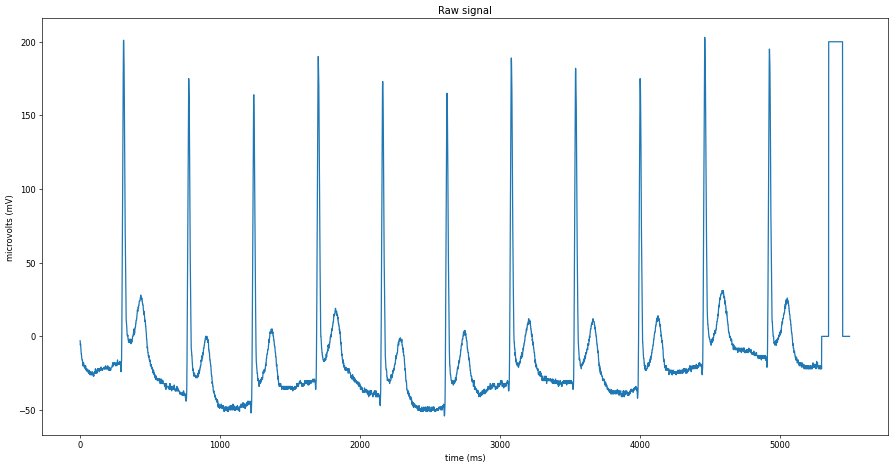

In [6]:
plt.figure(figsize=(15,15), dpi= 60)
plt.subplot(2, 1, 1)
plt.plot(ecg_dataframe[ecg_dataframe['lead']=='MDC_ECG_LEAD_I'].mV[0])
plt.xlabel('time (ms)')
plt.ylabel('microvolts (mV)')
plt.title("Raw signal")
plt.tight_layout()
plt.show()

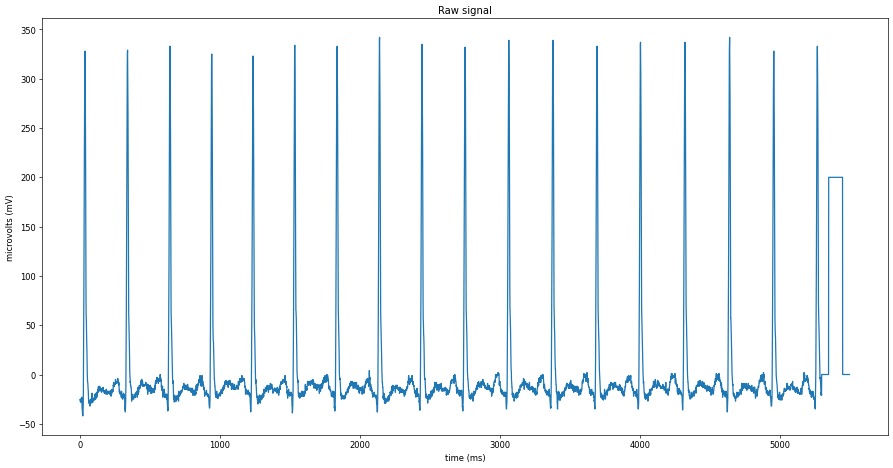

In [7]:
plt.figure(figsize=(15,15), dpi= 60)
plt.subplot(2, 1, 1)
plt.plot(ecg_dataframe[ecg_dataframe['lead']=='MDC_ECG_LEAD_I'].mV[12])
plt.xlabel('time (ms)')
plt.ylabel('microvolts (mV)')
plt.title("Raw signal")
plt.tight_layout()
plt.show()

In [8]:
ecg_dataframe[ecg_dataframe['lead']=='MDC_ECG_LEAD_I'].severity[120]

0.0

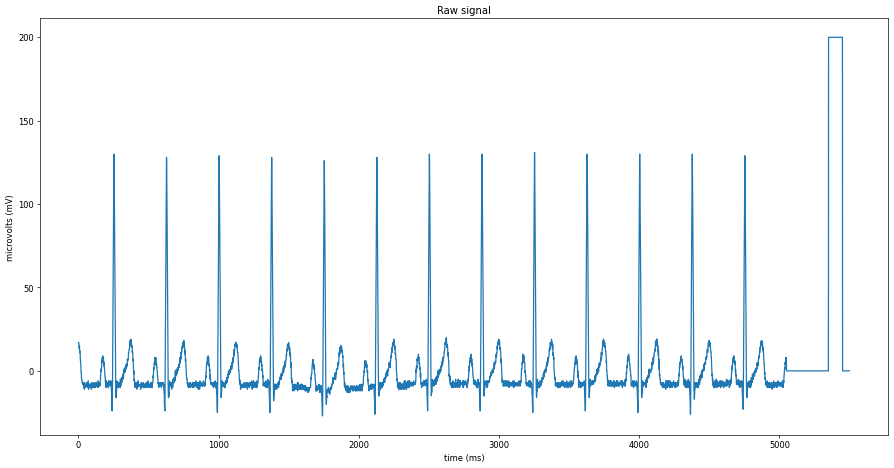

In [9]:
plt.figure(figsize=(15,15), dpi= 60)
plt.subplot(2, 1, 1)
plt.plot(ecg_dataframe[ecg_dataframe['lead']=='MDC_ECG_LEAD_I'].mV[120])
plt.xlabel('time (ms)')
plt.ylabel('microvolts (mV)')
plt.title("Raw signal")
plt.tight_layout()
plt.show()

# Data group by lead name

In [10]:
lead = pd.DataFrame({})
lead_sev = pd.DataFrame({})

In [11]:
for lead_name in ['MDC_ECG_LEAD_I', 'MDC_ECG_LEAD_II', 'MDC_ECG_LEAD_III', 'MDC_ECG_LEAD_AVR' , 'MDC_ECG_LEAD_AVL', 'MDC_ECG_LEAD_AVF', 
             'MDC_ECG_LEAD_V1', 'MDC_ECG_LEAD_V2', 'MDC_ECG_LEAD_V3', 'MDC_ECG_LEAD_V4', 'MDC_ECG_LEAD_V5', 'MDC_ECG_LEAD_V6']:

  lead[lead_name] = [np.array(ecg_dataframe[ecg_dataframe['lead']==lead_name].mV.tolist())]
  lead_sev[lead_name] = [np.array(ecg_dataframe[ecg_dataframe['lead']==lead_name].severity.tolist())]

# Data normalization

In [12]:
lead['MDC_ECG_LEAD_V2'][0]

array([[10.,  7.,  5., ...,  0.,  0.,  0.],
       [ 4.,  5.,  5., ...,  0.,  0.,  0.],
       [33., 31., 31., ...,  0.,  0.,  0.],
       ...,
       [23., 21., 21., ...,  0.,  0.,  0.],
       [40., 39., 39., ...,  0.,  0.,  0.],
       [ 5.,  7.,  8., ...,  0.,  0.,  0.]])

In [13]:
for lead_name in ['MDC_ECG_LEAD_I', 'MDC_ECG_LEAD_II', 'MDC_ECG_LEAD_III', 'MDC_ECG_LEAD_AVR' , 'MDC_ECG_LEAD_AVL', 'MDC_ECG_LEAD_AVF', 
             'MDC_ECG_LEAD_V1', 'MDC_ECG_LEAD_V2', 'MDC_ECG_LEAD_V3', 'MDC_ECG_LEAD_V4', 'MDC_ECG_LEAD_V5', 'MDC_ECG_LEAD_V6']:
  scaler = preprocessing.MinMaxScaler()
  lead[lead_name][0] = scaler.fit_transform(lead[lead_name][0])

In [14]:
lead['MDC_ECG_LEAD_V2'][0]

array([[0.97738033, 0.97423764, 0.96755625, ..., 0.        , 0.        ,
        0.        ],
       [0.97422409, 0.97318612, 0.96755625, ..., 0.        , 0.        ,
        0.        ],
       [0.98947922, 0.98685594, 0.9811617 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.98421883, 0.98159832, 0.97592883, ..., 0.        , 0.        ,
        0.        ],
       [0.99316149, 0.99106204, 0.98534799, ..., 0.        , 0.        ,
        0.        ],
       [0.97475013, 0.97423764, 0.96912611, ..., 0.        , 0.        ,
        0.        ]])

In [15]:
"""
for lead_name in ['MDC_ECG_LEAD_I', 'MDC_ECG_LEAD_II', 'MDC_ECG_LEAD_III', 'MDC_ECG_LEAD_AVR' , 'MDC_ECG_LEAD_AVL', 'MDC_ECG_LEAD_AVF', 
             'MDC_ECG_LEAD_V1', 'MDC_ECG_LEAD_V2', 'MDC_ECG_LEAD_V3', 'MDC_ECG_LEAD_V4', 'MDC_ECG_LEAD_V5', 'MDC_ECG_LEAD_V6']:
  lead[lead_name][0] = lead[lead_name][0].reshape(lead[lead_name][0].shape[0],5500,1)
  lead_sev[lead_name][0] = lead_sev[lead_name][0].reshape(lead_sev[lead_name][0].shape[0],1)
"""

"\nfor lead_name in ['MDC_ECG_LEAD_I', 'MDC_ECG_LEAD_II', 'MDC_ECG_LEAD_III', 'MDC_ECG_LEAD_AVR' , 'MDC_ECG_LEAD_AVL', 'MDC_ECG_LEAD_AVF', \n             'MDC_ECG_LEAD_V1', 'MDC_ECG_LEAD_V2', 'MDC_ECG_LEAD_V3', 'MDC_ECG_LEAD_V4', 'MDC_ECG_LEAD_V5', 'MDC_ECG_LEAD_V6']:\n  lead[lead_name][0] = lead[lead_name][0].reshape(lead[lead_name][0].shape[0],5500,1)\n  lead_sev[lead_name][0] = lead_sev[lead_name][0].reshape(lead_sev[lead_name][0].shape[0],1)\n"

# RNN LSTM building

## Modelo 1

Fit MDC_ECG_LEAD_I


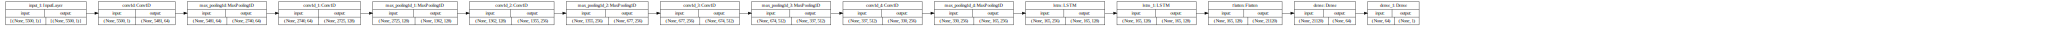

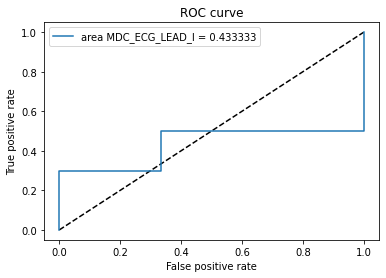

Fit MDC_ECG_LEAD_II


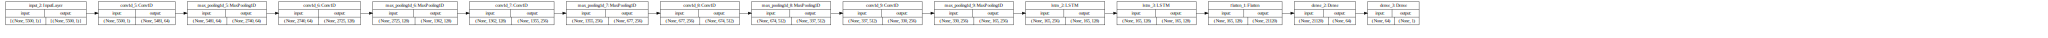

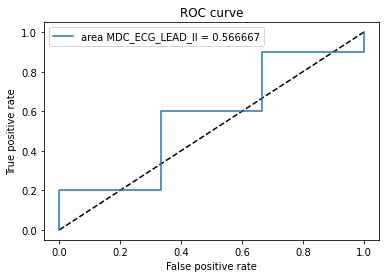

Fit MDC_ECG_LEAD_III


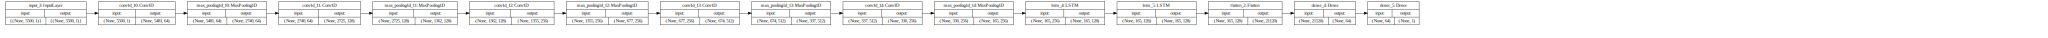

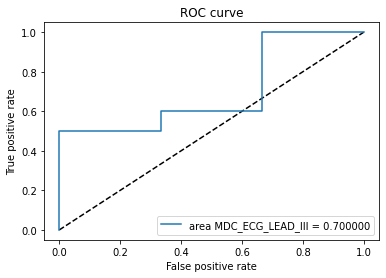

Fit MDC_ECG_LEAD_AVR


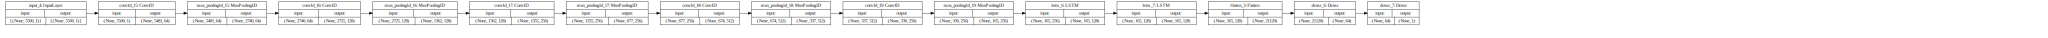

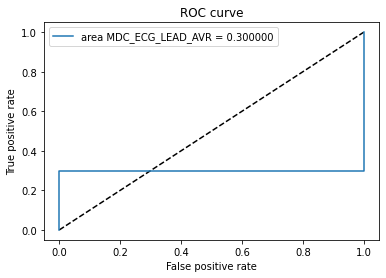

Fit MDC_ECG_LEAD_AVL


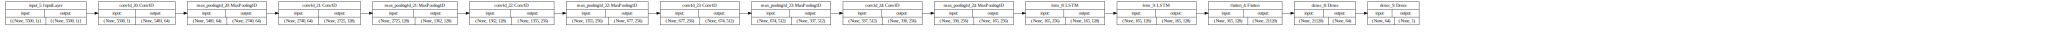

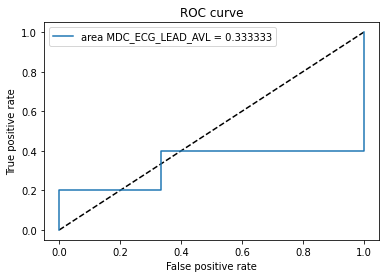

Fit MDC_ECG_LEAD_AVF


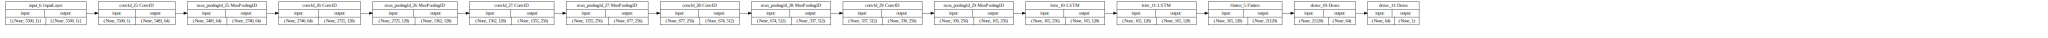

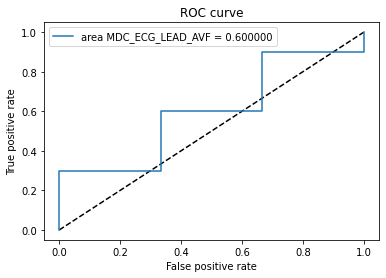

Fit MDC_ECG_LEAD_V1


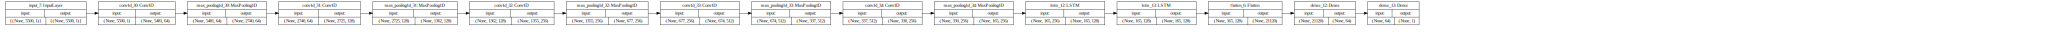

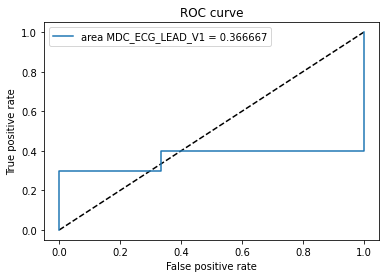

Fit MDC_ECG_LEAD_V2


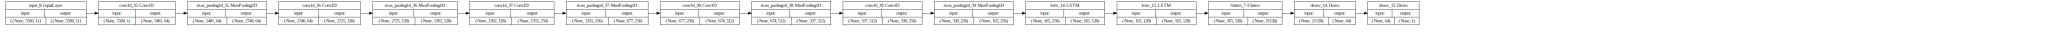

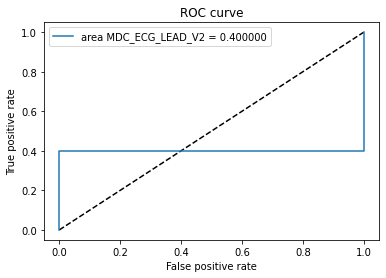

Fit MDC_ECG_LEAD_V3


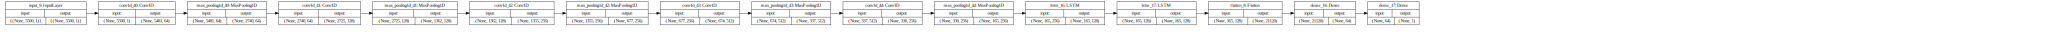

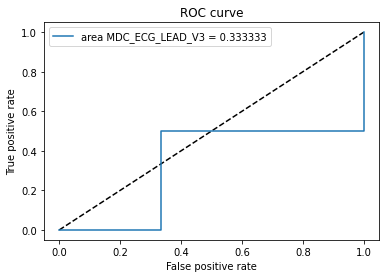

Fit MDC_ECG_LEAD_V4


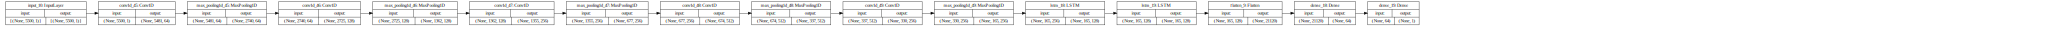

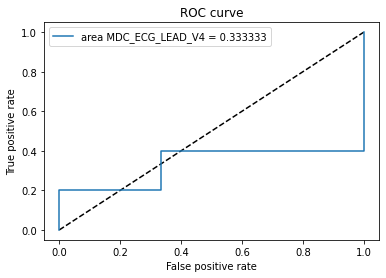

Fit MDC_ECG_LEAD_V5


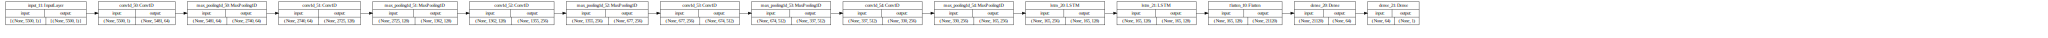

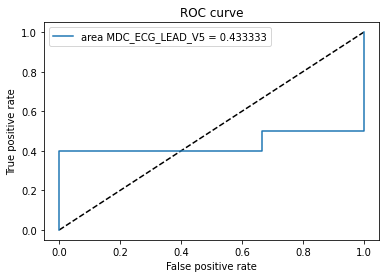

Fit MDC_ECG_LEAD_V6


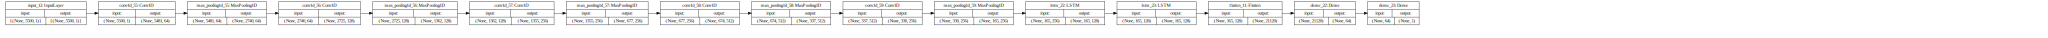

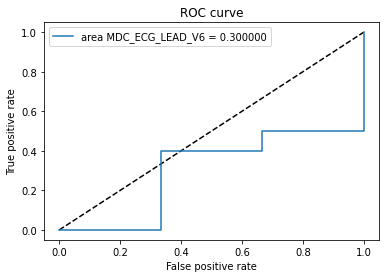

In [16]:
#import tensorflow as tf
#device_name = tf.test.gpu_device_name()
#if device_name != '/device:GPU:0':
#  raise SystemError('GPU device not found')
#print('Found GPU at: {}'.format(device_name))

history = pd.DataFrame({})

for lead_name in ['MDC_ECG_LEAD_I', 'MDC_ECG_LEAD_II', 'MDC_ECG_LEAD_III', 'MDC_ECG_LEAD_AVR' , 'MDC_ECG_LEAD_AVL', 'MDC_ECG_LEAD_AVF', 
             'MDC_ECG_LEAD_V1', 'MDC_ECG_LEAD_V2', 'MDC_ECG_LEAD_V3', 'MDC_ECG_LEAD_V4', 'MDC_ECG_LEAD_V5', 'MDC_ECG_LEAD_V6']:
  X = lead[lead_name][0]
  y = lead_sev[lead_name][0]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
 
  input = Input((5500,1))
  ecg_model = Conv1D(64,kernel_size=20)(input)
  ecg_model = MaxPooling1D(pool_size=2)(ecg_model)
  ecg_model = Conv1D(128,kernel_size=16)(ecg_model)
  ecg_model = MaxPooling1D(pool_size=2)(ecg_model)
  ecg_model = Conv1D(256,kernel_size=8)(ecg_model)
  ecg_model = MaxPooling1D(pool_size=2)(ecg_model)
  ecg_model = Conv1D(512,kernel_size=4)(ecg_model)
  ecg_model = MaxPooling1D(pool_size=2)(ecg_model)
  ecg_model = Conv1D(256,kernel_size=8)(ecg_model)
  ecg_model = MaxPooling1D(pool_size=2)(ecg_model)
  ecg_model = LSTM(128,  go_backwards=True, return_sequences=True)(ecg_model)
  ecg_model = LSTM(128, return_sequences=True)(ecg_model)
  ecg_model = Flatten()(ecg_model)
  ecg_model = Dense(64, activation='relu')(ecg_model)
  o  = Dense(1, activation='sigmoid')(ecg_model)

  model = Model(inputs = input, outputs = o)
  opt = Adam(lr=0.0000001)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=["accuracy"])
  print("Fit %s" % lead_name)
  history[lead_name] = [model.fit(X_train,y_train, epochs=100,verbose=0, validation_data=(X_test,y_test))]

  from IPython.display import SVG, display, clear_output
  from keras.utils.vis_utils import model_to_dot

  
  display(SVG(model_to_dot(model, show_shapes=True, dpi=50, rankdir='LR').create(prog='dot', format='svg')))

  from sklearn.metrics import roc_curve
  y_pred_keras = model.predict(X_test)

  fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

  from sklearn.metrics import auc
  auc_keras = auc(fpr_keras, tpr_keras)

  import matplotlib.pyplot as plt
  %matplotlib inline
  plt.figure(1)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr_keras, tpr_keras, label='area %s = %3f' % (lead_name, auc_keras))
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend(loc='best')
  plt.show()

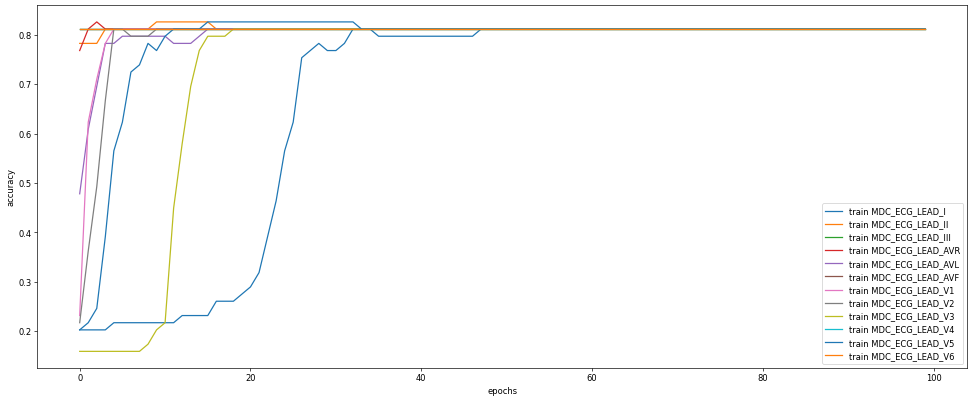

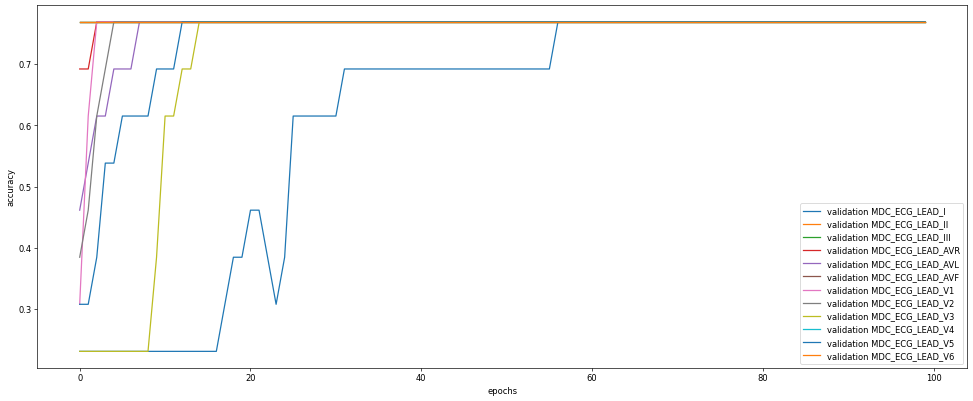

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20,8), dpi= 60)
for lead_name in ['MDC_ECG_LEAD_I', 'MDC_ECG_LEAD_II', 'MDC_ECG_LEAD_III', 'MDC_ECG_LEAD_AVR' , 'MDC_ECG_LEAD_AVL', 'MDC_ECG_LEAD_AVF', 
            'MDC_ECG_LEAD_V1', 'MDC_ECG_LEAD_V2', 'MDC_ECG_LEAD_V3', 'MDC_ECG_LEAD_V4', 'MDC_ECG_LEAD_V5', 'MDC_ECG_LEAD_V6']:
  plt.plot(history[lead_name][0].history['accuracy'],label='train %s' % lead_name)
  plt.ylabel('accuracy')
  plt.xlabel('epochs')
  plt.legend()

plt.show()

plt.figure(figsize=(20,8), dpi= 60)
for lead_name in ['MDC_ECG_LEAD_I', 'MDC_ECG_LEAD_II', 'MDC_ECG_LEAD_III', 'MDC_ECG_LEAD_AVR' , 'MDC_ECG_LEAD_AVL', 'MDC_ECG_LEAD_AVF', 
            'MDC_ECG_LEAD_V1', 'MDC_ECG_LEAD_V2', 'MDC_ECG_LEAD_V3', 'MDC_ECG_LEAD_V4', 'MDC_ECG_LEAD_V5', 'MDC_ECG_LEAD_V6']:
  plt.plot(history[lead_name][0].history['val_accuracy'],label='validation %s' % lead_name)
  plt.ylabel('accuracy')
  plt.xlabel('epochs')
  plt.legend()

plt.show()






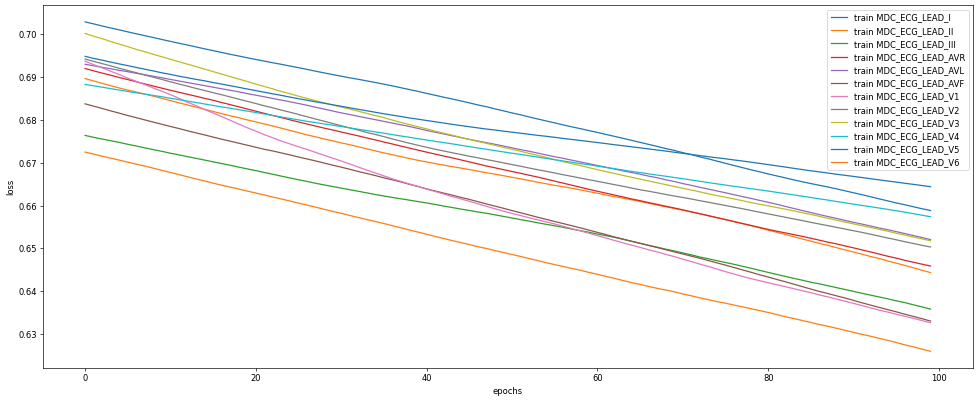

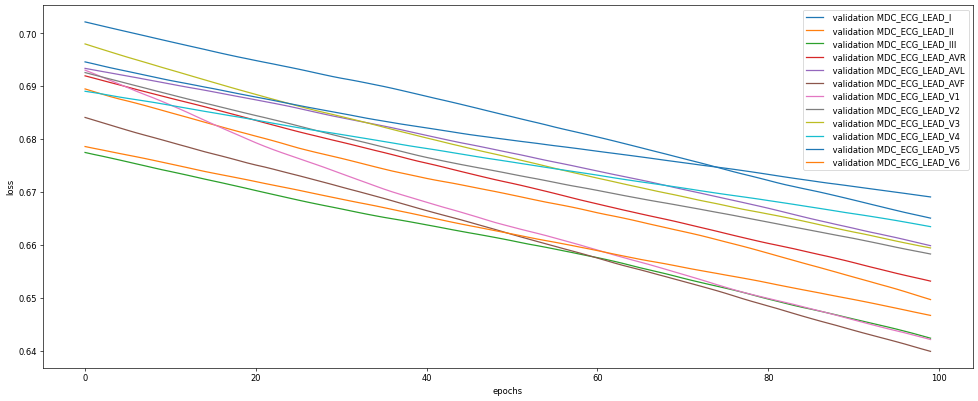

In [18]:
plt.figure(figsize=(20,8), dpi= 60)
for lead_name in ['MDC_ECG_LEAD_I', 'MDC_ECG_LEAD_II', 'MDC_ECG_LEAD_III', 'MDC_ECG_LEAD_AVR' , 'MDC_ECG_LEAD_AVL', 'MDC_ECG_LEAD_AVF', 
            'MDC_ECG_LEAD_V1', 'MDC_ECG_LEAD_V2', 'MDC_ECG_LEAD_V3', 'MDC_ECG_LEAD_V4', 'MDC_ECG_LEAD_V5', 'MDC_ECG_LEAD_V6']:
  #print(lead_name)
  plt.ylabel('loss')
  plt.xlabel('epochs')
  plt.plot(history[lead_name][0].history['loss'],label='train %s' % lead_name)
  plt.legend()
plt.show()

plt.figure(figsize=(20,8), dpi= 60)
for lead_name in ['MDC_ECG_LEAD_I', 'MDC_ECG_LEAD_II', 'MDC_ECG_LEAD_III', 'MDC_ECG_LEAD_AVR' , 'MDC_ECG_LEAD_AVL', 'MDC_ECG_LEAD_AVF', 
            'MDC_ECG_LEAD_V1', 'MDC_ECG_LEAD_V2', 'MDC_ECG_LEAD_V3', 'MDC_ECG_LEAD_V4', 'MDC_ECG_LEAD_V5', 'MDC_ECG_LEAD_V6']:
  #print(lead_name)

  plt.plot(history[lead_name][0].history['val_loss'],label=' validation %s' % lead_name)
  plt.ylabel('loss')
  plt.xlabel('epochs')
  plt.legend()
plt.show()

## Modelo 2

Fit MDC_ECG_LEAD_I


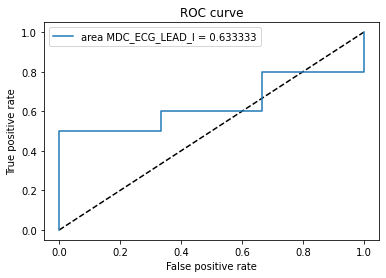

Fit MDC_ECG_LEAD_II


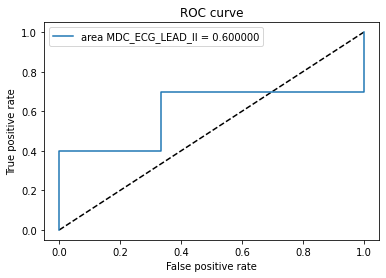

Fit MDC_ECG_LEAD_III


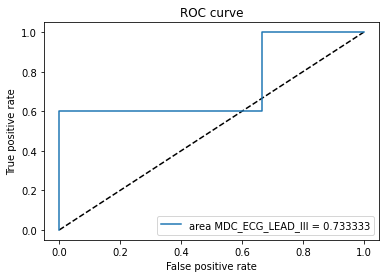

Fit MDC_ECG_LEAD_AVR


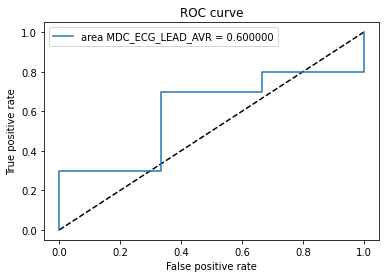

Fit MDC_ECG_LEAD_AVL


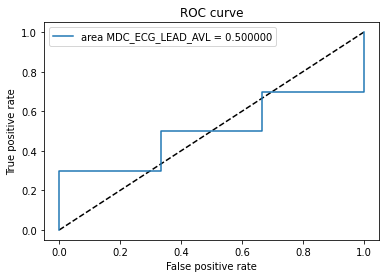

Fit MDC_ECG_LEAD_AVF


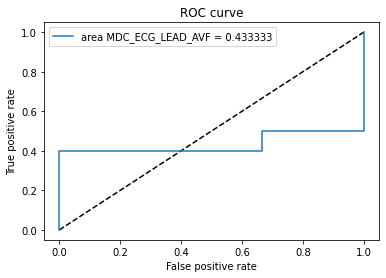

Fit MDC_ECG_LEAD_V1


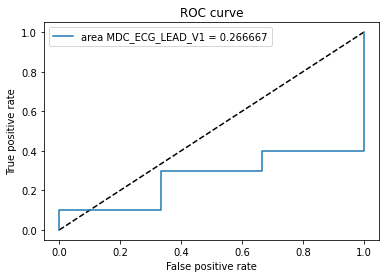

Fit MDC_ECG_LEAD_V2


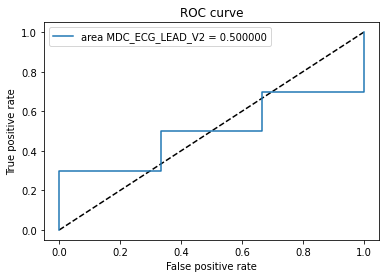

Fit MDC_ECG_LEAD_V3


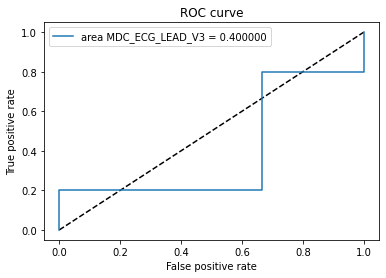

Fit MDC_ECG_LEAD_V4


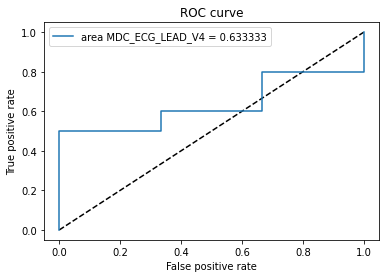

Fit MDC_ECG_LEAD_V5


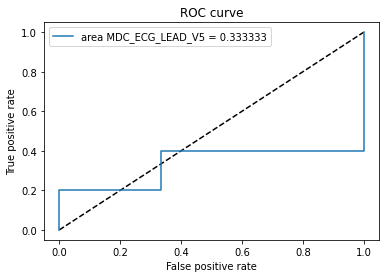

Fit MDC_ECG_LEAD_V6


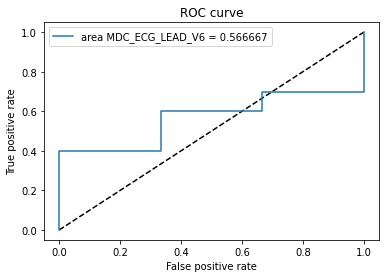

In [19]:

history2 = pd.DataFrame({})

for lead_name in ['MDC_ECG_LEAD_I', 'MDC_ECG_LEAD_II', 'MDC_ECG_LEAD_III', 'MDC_ECG_LEAD_AVR' , 'MDC_ECG_LEAD_AVL', 'MDC_ECG_LEAD_AVF', 
             'MDC_ECG_LEAD_V1', 'MDC_ECG_LEAD_V2', 'MDC_ECG_LEAD_V3', 'MDC_ECG_LEAD_V4', 'MDC_ECG_LEAD_V5', 'MDC_ECG_LEAD_V6']:
  X = lead[lead_name][0]
  y = lead_sev[lead_name][0]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

  input = Input((5500,1))
  ecg_model = Conv1D(64,kernel_size=21,strides=11)(input)
  ecg_model = MaxPooling1D(pool_size=2)(ecg_model)
  ecg_model = BatchNormalization()(ecg_model)
  ecg_model = LeakyReLU(alpha=0.1)(ecg_model)
  ecg_model = Dropout(rate=0.3)(ecg_model)
  ecg_model = Conv1D(64,kernel_size=7,strides=1)(ecg_model)
  ecg_model = MaxPooling1D(pool_size=2)(ecg_model)
  ecg_model = BatchNormalization()(ecg_model)
  ecg_model = Conv1D(128,kernel_size=5,strides=1)(ecg_model)
  ecg_model = MaxPooling1D(pool_size=2)(ecg_model)
  ecg_model = Conv1D(256,kernel_size=13,strides=1)(ecg_model)
  ecg_model = Conv1D(512,kernel_size=7,strides=1)(ecg_model)
  ecg_model = Dropout(rate=0.3)(ecg_model)
  ecg_model = Conv1D(256,kernel_size=9,strides=1)(ecg_model)
  ecg_model = MaxPooling1D(pool_size=2)(ecg_model)
  ecg_model = LSTM(128, return_sequences=True)(ecg_model)
  ecg_model = Flatten()(ecg_model)
  ecg_model = Dense(64, activation='relu')(ecg_model)
  o  = Dense(1, activation='sigmoid')(ecg_model)

  model = Model(inputs = input, outputs = o)
  opt = Adam(lr=0.00000000001)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=["accuracy"])
  print("Fit %s" % lead_name)
  history2[lead_name] = [model.fit(X_train,y_train, epochs=100,verbose=0,validation_data=(X_test,y_test))]

  from IPython.display import SVG, display, clear_output
  from keras.utils.vis_utils import model_to_dot

  display(SVG(model_to_dot(model, show_shapes=True, dpi=50, rankdir='LR').create(prog='dot', format='svg')))

  from sklearn.metrics import roc_curve
  y_pred_keras = model.predict(X_test)

  fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

  from sklearn.metrics import auc
  auc_keras = auc(fpr_keras, tpr_keras)

  import matplotlib.pyplot as plt
  %matplotlib inline
  plt.figure(1)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr_keras, tpr_keras, label='area %s = %3f' % (lead_name, auc_keras))
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend(loc='best')
  plt.show()

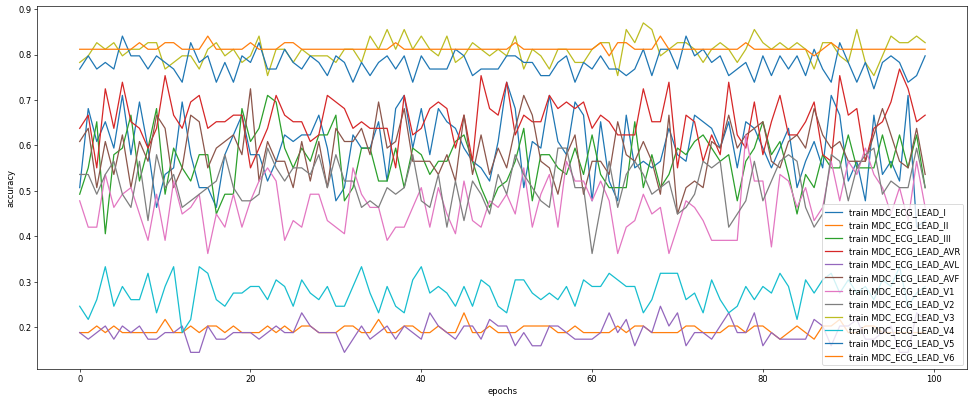

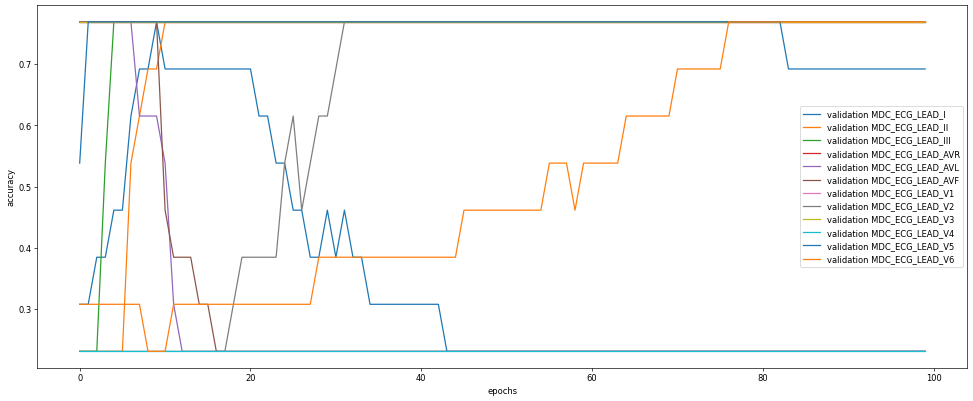

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20,8), dpi= 60)
for lead_name in ['MDC_ECG_LEAD_I', 'MDC_ECG_LEAD_II', 'MDC_ECG_LEAD_III', 'MDC_ECG_LEAD_AVR' , 'MDC_ECG_LEAD_AVL', 'MDC_ECG_LEAD_AVF', 
            'MDC_ECG_LEAD_V1', 'MDC_ECG_LEAD_V2', 'MDC_ECG_LEAD_V3', 'MDC_ECG_LEAD_V4', 'MDC_ECG_LEAD_V5', 'MDC_ECG_LEAD_V6']:
  plt.plot(history2[lead_name][0].history['accuracy'],label='train %s' % lead_name)
  plt.ylabel('accuracy')
  plt.xlabel('epochs')
  plt.legend()

plt.show()

plt.figure(figsize=(20,8), dpi= 60)
for lead_name in ['MDC_ECG_LEAD_I', 'MDC_ECG_LEAD_II', 'MDC_ECG_LEAD_III', 'MDC_ECG_LEAD_AVR' , 'MDC_ECG_LEAD_AVL', 'MDC_ECG_LEAD_AVF', 
            'MDC_ECG_LEAD_V1', 'MDC_ECG_LEAD_V2', 'MDC_ECG_LEAD_V3', 'MDC_ECG_LEAD_V4', 'MDC_ECG_LEAD_V5', 'MDC_ECG_LEAD_V6']:
  plt.plot(history2[lead_name][0].history['val_accuracy'],label='validation %s' % lead_name)
  plt.ylabel('accuracy')
  plt.xlabel('epochs')
  plt.legend()

plt.show()




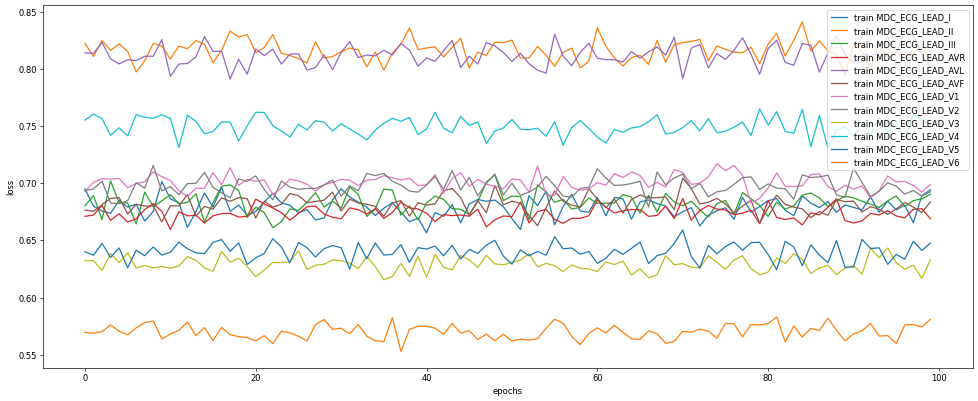

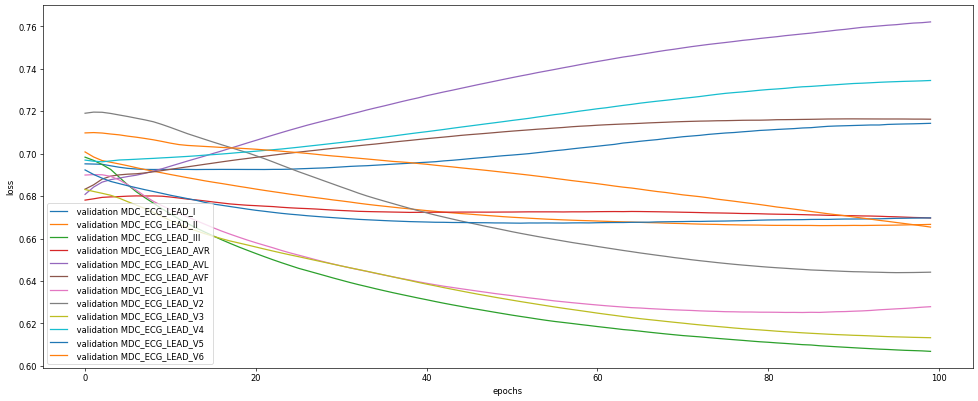

In [21]:
plt.figure(figsize=(20,8), dpi= 60)
for lead_name in ['MDC_ECG_LEAD_I', 'MDC_ECG_LEAD_II', 'MDC_ECG_LEAD_III', 'MDC_ECG_LEAD_AVR' , 'MDC_ECG_LEAD_AVL', 'MDC_ECG_LEAD_AVF', 
            'MDC_ECG_LEAD_V1', 'MDC_ECG_LEAD_V2', 'MDC_ECG_LEAD_V3', 'MDC_ECG_LEAD_V4', 'MDC_ECG_LEAD_V5', 'MDC_ECG_LEAD_V6']:
  #print(lead_name)
  plt.ylabel('loss')
  plt.xlabel('epochs')
  plt.plot(history2[lead_name][0].history['loss'],label='train %s' % lead_name)
  plt.legend()
plt.show()

plt.figure(figsize=(20,8), dpi= 60)
for lead_name in ['MDC_ECG_LEAD_I', 'MDC_ECG_LEAD_II', 'MDC_ECG_LEAD_III', 'MDC_ECG_LEAD_AVR' , 'MDC_ECG_LEAD_AVL', 'MDC_ECG_LEAD_AVF', 
            'MDC_ECG_LEAD_V1', 'MDC_ECG_LEAD_V2', 'MDC_ECG_LEAD_V3', 'MDC_ECG_LEAD_V4', 'MDC_ECG_LEAD_V5', 'MDC_ECG_LEAD_V6']:
  #print(lead_name)

  plt.plot(history2[lead_name][0].history['val_loss'],label=' validation %s' % lead_name)
  plt.ylabel('loss')
  plt.xlabel('epochs')
  plt.legend()
plt.show()

## Modelo 3

Fit MDC_ECG_LEAD_I


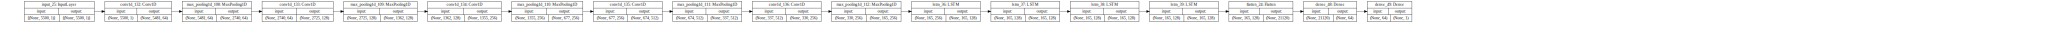

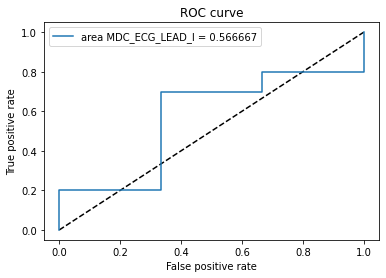

Fit MDC_ECG_LEAD_II


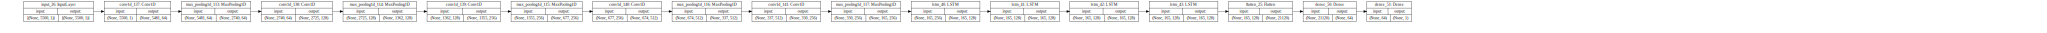

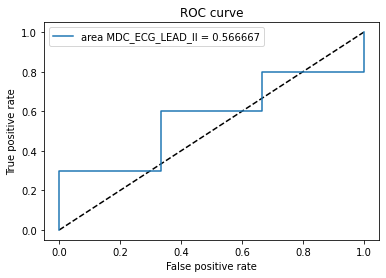

Fit MDC_ECG_LEAD_III


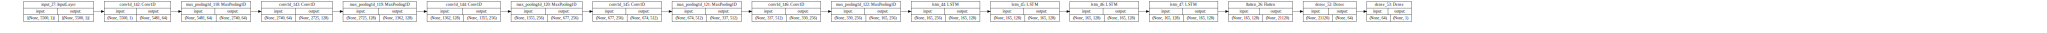

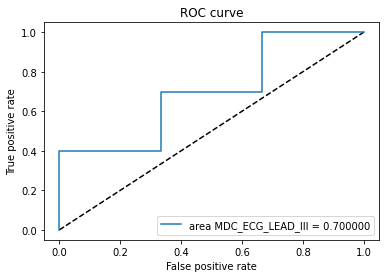

Fit MDC_ECG_LEAD_AVR


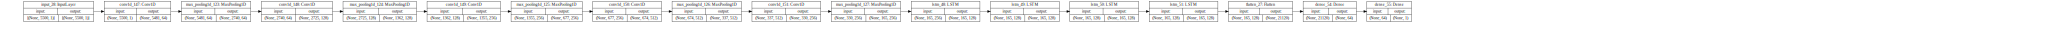

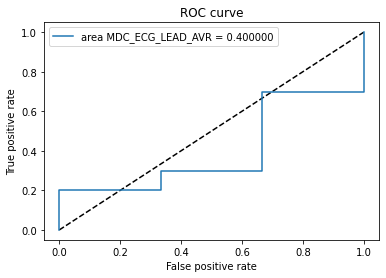

Fit MDC_ECG_LEAD_AVL


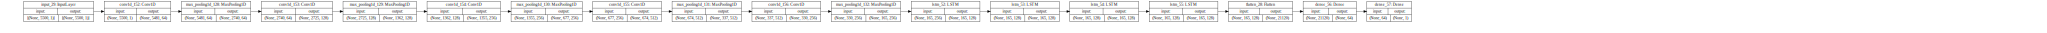

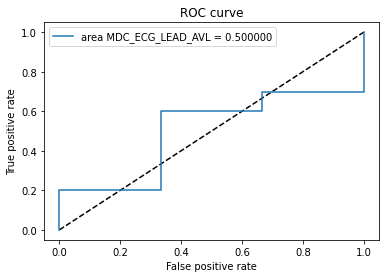

Fit MDC_ECG_LEAD_AVF


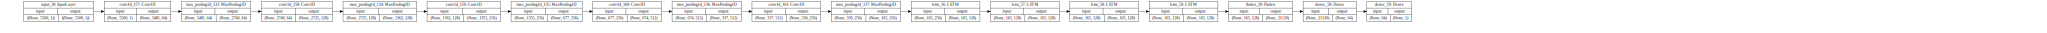

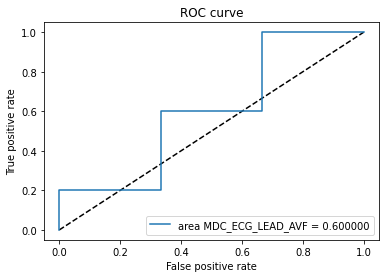

Fit MDC_ECG_LEAD_V1


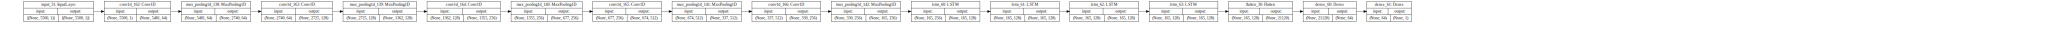

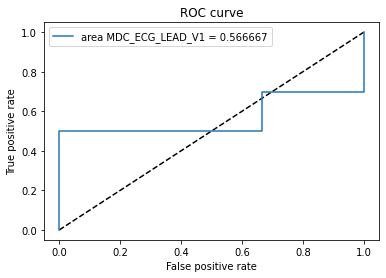

Fit MDC_ECG_LEAD_V2


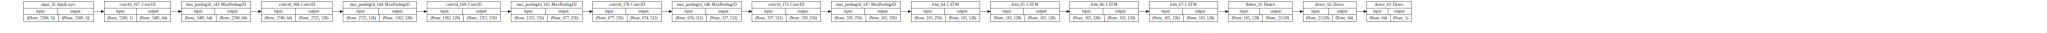

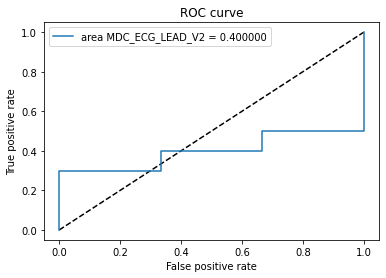

Fit MDC_ECG_LEAD_V3


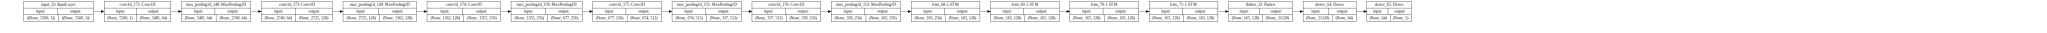

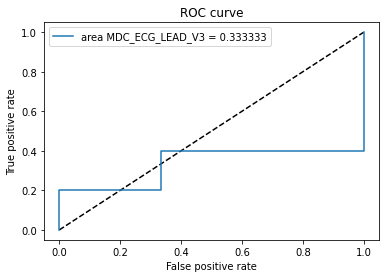

Fit MDC_ECG_LEAD_V4


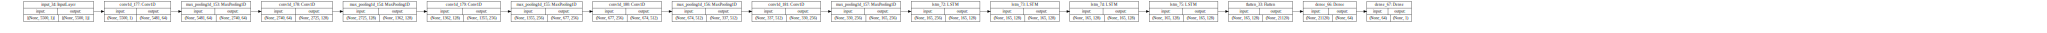

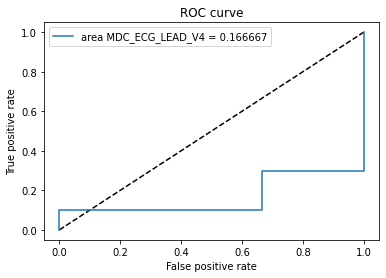

Fit MDC_ECG_LEAD_V5


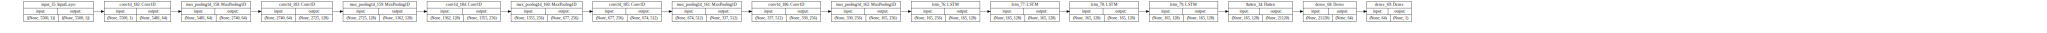

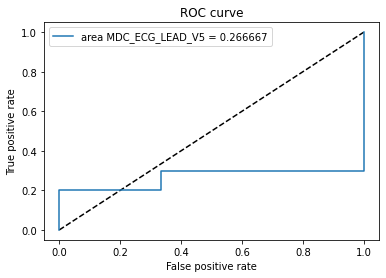

Fit MDC_ECG_LEAD_V6


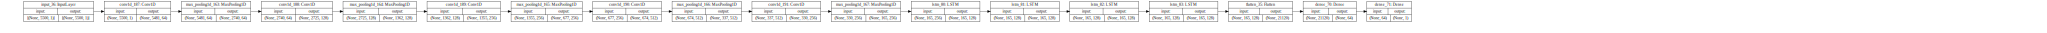

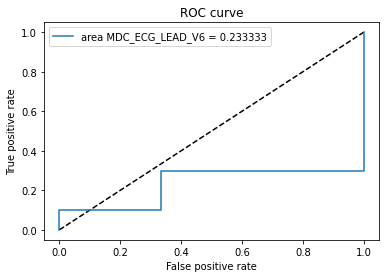

In [22]:

history3 = pd.DataFrame({})

for lead_name in ['MDC_ECG_LEAD_I', 'MDC_ECG_LEAD_II', 'MDC_ECG_LEAD_III', 'MDC_ECG_LEAD_AVR' , 'MDC_ECG_LEAD_AVL', 'MDC_ECG_LEAD_AVF', 
             'MDC_ECG_LEAD_V1', 'MDC_ECG_LEAD_V2', 'MDC_ECG_LEAD_V3', 'MDC_ECG_LEAD_V4', 'MDC_ECG_LEAD_V5', 'MDC_ECG_LEAD_V6']:
  X = lead[lead_name][0]
  y = lead_sev[lead_name][0]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

  input = Input((5500,1))
  ecg_model = Conv1D(64,kernel_size=20)(input)
  ecg_model = MaxPooling1D(pool_size=2)(ecg_model)
  ecg_model = Conv1D(128,kernel_size=16)(ecg_model)
  ecg_model = MaxPooling1D(pool_size=2)(ecg_model)
  ecg_model = Conv1D(256,kernel_size=8)(ecg_model)
  ecg_model = MaxPooling1D(pool_size=2)(ecg_model)
  ecg_model = Conv1D(512,kernel_size=4)(ecg_model)
  ecg_model = MaxPooling1D(pool_size=2)(ecg_model)
  ecg_model = Conv1D(256,kernel_size=8)(ecg_model)
  ecg_model = MaxPooling1D(pool_size=2)(ecg_model)
  ecg_model = LSTM(128,  go_backwards=True, return_sequences=True)(ecg_model)
  ecg_model = LSTM(128, go_backwards=True, return_sequences=True)(ecg_model)
  ecg_model = LSTM(128,  go_backwards=True, return_sequences=True)(ecg_model)
  ecg_model = LSTM(128, go_backwards=True, return_sequences=True)(ecg_model)
  ecg_model = Flatten()(ecg_model)
  ecg_model = Dense(64, activation='relu')(ecg_model)
  o  = Dense(1, activation='sigmoid')(ecg_model)

  model = Model(inputs = input, outputs = o)
  model_t = model
  opt = Adam(lr=0.0000001)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=["accuracy"])
  print("Fit %s" % lead_name)
  history3[lead_name] = [model.fit(X_train,y_train, epochs=100,verbose=0, validation_data=(X_test,y_test))]

  from IPython.display import SVG, display, clear_output
  from keras.utils.vis_utils import model_to_dot

  display(SVG(model_to_dot(model, show_shapes=True, dpi=50, rankdir='LR').create(prog='dot', format='svg')))
  
  from sklearn.metrics import roc_curve
  y_pred_keras = model.predict(X_test)

  fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

  from sklearn.metrics import auc
  auc_keras = auc(fpr_keras, tpr_keras)

  import matplotlib.pyplot as plt
  %matplotlib inline
  plt.figure(1)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr_keras, tpr_keras, label='area %s = %3f' % (lead_name, auc_keras))
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend(loc='best')
  plt.show()

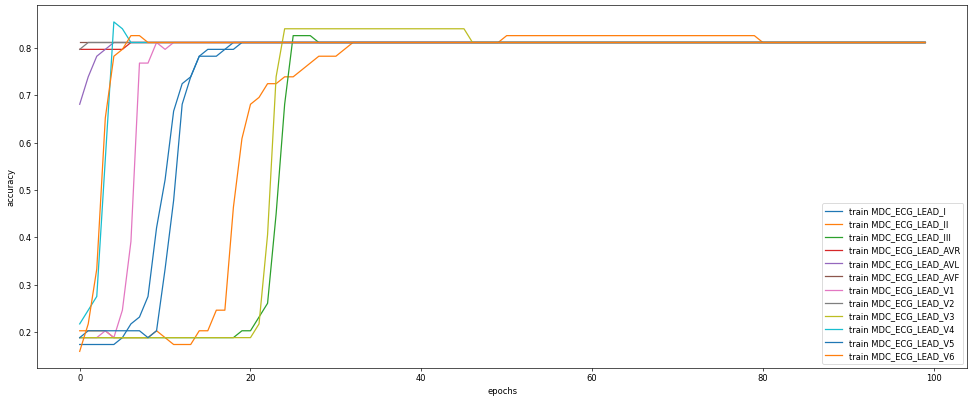

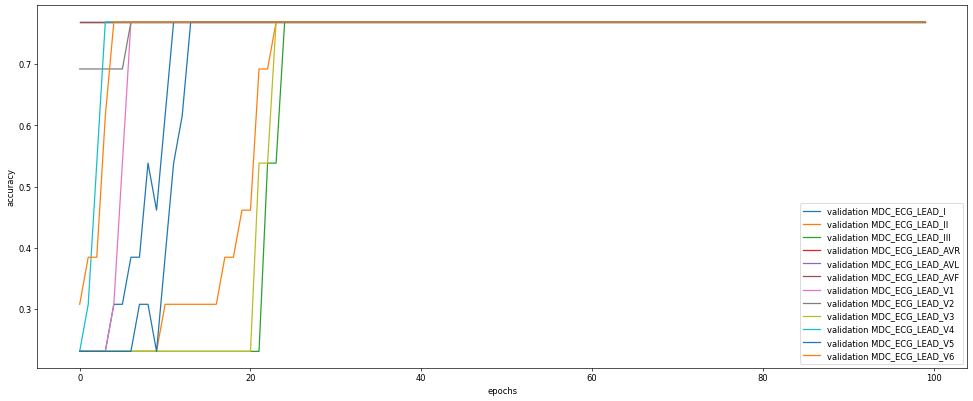

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20,8), dpi= 60)
for lead_name in ['MDC_ECG_LEAD_I', 'MDC_ECG_LEAD_II', 'MDC_ECG_LEAD_III', 'MDC_ECG_LEAD_AVR' , 'MDC_ECG_LEAD_AVL', 'MDC_ECG_LEAD_AVF', 
            'MDC_ECG_LEAD_V1', 'MDC_ECG_LEAD_V2', 'MDC_ECG_LEAD_V3', 'MDC_ECG_LEAD_V4', 'MDC_ECG_LEAD_V5', 'MDC_ECG_LEAD_V6']:
  plt.plot(history3[lead_name][0].history['accuracy'],label='train %s' % lead_name)
  plt.ylabel('accuracy')
  plt.xlabel('epochs')
  plt.legend()

plt.show()

plt.figure(figsize=(20,8), dpi= 60)
for lead_name in ['MDC_ECG_LEAD_I', 'MDC_ECG_LEAD_II', 'MDC_ECG_LEAD_III', 'MDC_ECG_LEAD_AVR' , 'MDC_ECG_LEAD_AVL', 'MDC_ECG_LEAD_AVF', 
            'MDC_ECG_LEAD_V1', 'MDC_ECG_LEAD_V2', 'MDC_ECG_LEAD_V3', 'MDC_ECG_LEAD_V4', 'MDC_ECG_LEAD_V5', 'MDC_ECG_LEAD_V6']:
  plt.plot(history3[lead_name][0].history['val_accuracy'],label='validation %s' % lead_name)
  plt.ylabel('accuracy')
  plt.xlabel('epochs')
  plt.legend()

plt.show()


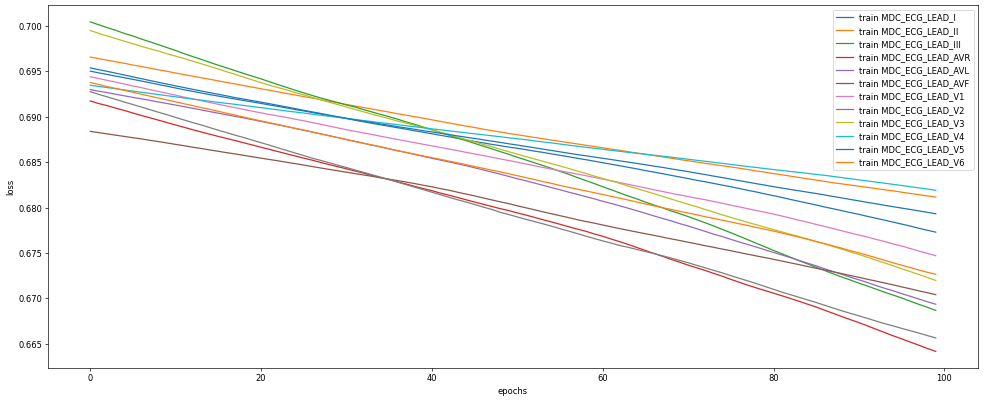

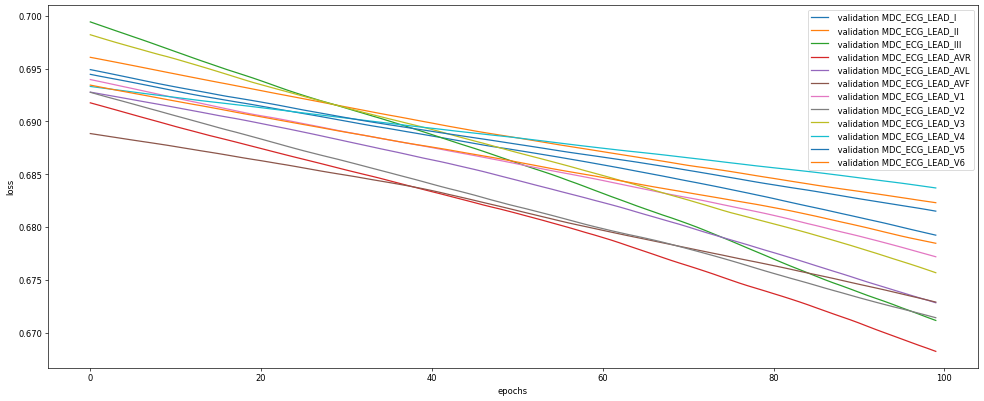

In [24]:


plt.figure(figsize=(20,8), dpi= 60)
for lead_name in ['MDC_ECG_LEAD_I', 'MDC_ECG_LEAD_II', 'MDC_ECG_LEAD_III', 'MDC_ECG_LEAD_AVR' , 'MDC_ECG_LEAD_AVL', 'MDC_ECG_LEAD_AVF', 
            'MDC_ECG_LEAD_V1', 'MDC_ECG_LEAD_V2', 'MDC_ECG_LEAD_V3', 'MDC_ECG_LEAD_V4', 'MDC_ECG_LEAD_V5', 'MDC_ECG_LEAD_V6']:
  #print(lead_name)
  plt.ylabel('loss')
  plt.xlabel('epochs')
  plt.plot(history3[lead_name][0].history['loss'],label='train %s' % lead_name)
  plt.legend()
plt.show()

plt.figure(figsize=(20,8), dpi= 60)
for lead_name in ['MDC_ECG_LEAD_I', 'MDC_ECG_LEAD_II', 'MDC_ECG_LEAD_III', 'MDC_ECG_LEAD_AVR' , 'MDC_ECG_LEAD_AVL', 'MDC_ECG_LEAD_AVF', 
            'MDC_ECG_LEAD_V1', 'MDC_ECG_LEAD_V2', 'MDC_ECG_LEAD_V3', 'MDC_ECG_LEAD_V4', 'MDC_ECG_LEAD_V5', 'MDC_ECG_LEAD_V6']:
  #print(lead_name)

  plt.plot(history3[lead_name][0].history['val_loss'],label=' validation %s' % lead_name)
  plt.ylabel('loss')
  plt.xlabel('epochs')
  plt.legend()
plt.show()

## Modelo 4

In [25]:

#for lead_name in ['MDC_ECG_LEAD_I', 'MDC_ECG_LEAD_II', 'MDC_ECG_LEAD_III', 'MDC_ECG_LEAD_AVR' , 'MDC_ECG_LEAD_AVL', 'MDC_ECG_LEAD_AVF', 
#             'MDC_ECG_LEAD_V1', 'MDC_ECG_LEAD_V2', 'MDC_ECG_LEAD_V3', 'MDC_ECG_LEAD_V4', 'MDC_ECG_LEAD_V5', 'MDC_ECG_LEAD_V6']:

X_LEAD_I = lead['MDC_ECG_LEAD_I'][0]
y_LEAD_I = lead_sev['MDC_ECG_LEAD_I'][0]
X_train_LEAD_I , X_test_LEAD_I , y_train_LEAD_I , y_test_LEAD_I  = train_test_split(X_LEAD_I, y_LEAD_I, test_size=0.15, random_state=42)

X_LEAD_II = lead['MDC_ECG_LEAD_II'][0]
y_LEAD_II = lead_sev['MDC_ECG_LEAD_II'][0]
X_train_LEAD_II , X_test_LEAD_II , y_train_LEAD_II , y_test_LEAD_II  = train_test_split(X_LEAD_II, y_LEAD_II, test_size=0.15, random_state=42)

X_LEAD_III = lead['MDC_ECG_LEAD_III'][0]
y_LEAD_III = lead_sev['MDC_ECG_LEAD_III'][0]
X_train_LEAD_III , X_test_LEAD_III , y_train_LEAD_III , y_test_LEAD_III  = train_test_split(X_LEAD_III, y_LEAD_III, test_size=0.15, random_state=42)

X_LEAD_AVR = lead['MDC_ECG_LEAD_AVR'][0]
y_LEAD_AVR = lead_sev['MDC_ECG_LEAD_AVR'][0]
X_train_LEAD_AVR , X_test_LEAD_AVR , y_train_LEAD_AVR , y_test_LEAD_AVR  = train_test_split(X_LEAD_AVR, y_LEAD_AVR, test_size=0.15, random_state=42)

X_LEAD_AVL = lead['MDC_ECG_LEAD_AVL'][0]
y_LEAD_AVL = lead_sev['MDC_ECG_LEAD_AVL'][0]
X_train_LEAD_AVL , X_test_LEAD_AVL , y_train_LEAD_AVL , y_test_LEAD_AVL  = train_test_split(X_LEAD_AVL, y_LEAD_AVL, test_size=0.15, random_state=42)

X_LEAD_AVF = lead['MDC_ECG_LEAD_AVF'][0]
y_LEAD_AVF = lead_sev['MDC_ECG_LEAD_AVF'][0]
X_train_LEAD_AVF , X_test_LEAD_AVF , y_train_LEAD_AVF , y_test_LEAD_AVF  = train_test_split(X_LEAD_AVF, y_LEAD_AVF, test_size=0.15, random_state=42)

X_LEAD_V1 = lead['MDC_ECG_LEAD_V1'][0]
y_LEAD_V1 = lead_sev['MDC_ECG_LEAD_V1'][0]
X_train_LEAD_V1 , X_test_LEAD_V1 , y_train_LEAD_V1 , y_test_LEAD_V1  = train_test_split(X_LEAD_V1, y_LEAD_V1, test_size=0.15, random_state=42)

X_LEAD_V2 = lead['MDC_ECG_LEAD_V2'][0]
y_LEAD_V2 = lead_sev['MDC_ECG_LEAD_V2'][0]
X_train_LEAD_V2 , X_test_LEAD_V2 , y_train_LEAD_V2 , y_test_LEAD_V2  = train_test_split(X_LEAD_V2, y_LEAD_V2, test_size=0.15, random_state=42)

X_LEAD_V3 = lead['MDC_ECG_LEAD_V3'][0]
y_LEAD_V3 = lead_sev['MDC_ECG_LEAD_V3'][0]
X_train_LEAD_V3 , X_test_LEAD_V3 , y_train_LEAD_V3 , y_test_LEAD_V3  = train_test_split(X_LEAD_V3, y_LEAD_V3, test_size=0.15, random_state=42)

X_LEAD_V4 = lead['MDC_ECG_LEAD_V4'][0]
y_LEAD_V4 = lead_sev['MDC_ECG_LEAD_V4'][0]
X_train_LEAD_V4 , X_test_LEAD_V4 , y_train_LEAD_V4 , y_test_LEAD_V4  = train_test_split(X_LEAD_V4, y_LEAD_V4, test_size=0.15, random_state=42)

X_LEAD_V5 = lead['MDC_ECG_LEAD_V5'][0]
y_LEAD_V5 = lead_sev['MDC_ECG_LEAD_V5'][0]
X_train_LEAD_V5 , X_test_LEAD_V5 , y_train_LEAD_V5 , y_test_LEAD_V5  = train_test_split(X_LEAD_V5, y_LEAD_V5, test_size=0.15, random_state=42)

X_LEAD_V6 = lead['MDC_ECG_LEAD_V6'][0]
y_LEAD_V6 = lead_sev['MDC_ECG_LEAD_V6'][0]
X_train_LEAD_V6 , X_test_LEAD_V6 , y_train_LEAD_V6 , y_test_LEAD_V6  = train_test_split(X_LEAD_V6, y_LEAD_V6, test_size=0.15, random_state=42)

In [26]:
lead_1_inp = Input((5500,1))
lead_1_LSTM = Conv1D(64,kernel_size=20)(lead_1_inp)
lead_1_LSTM = MaxPooling1D(pool_size=2)(lead_1_LSTM)
lead_1_LSTM = Conv1D(128,kernel_size=16)(lead_1_LSTM)
lead_1_LSTM = MaxPooling1D(pool_size=2)(lead_1_LSTM)
lead_1_LSTM = Conv1D(256,kernel_size=8)(lead_1_LSTM)
lead_1_LSTM = MaxPooling1D(pool_size=2)(lead_1_LSTM)
lead_1_LSTM = Conv1D(512,kernel_size=4)(lead_1_LSTM)
lead_1_LSTM = MaxPooling1D(pool_size=2)(lead_1_LSTM)
lead_1_LSTM = Conv1D(256,kernel_size=8)(lead_1_LSTM)
lead_1_LSTM = MaxPooling1D(pool_size=2)(lead_1_LSTM)
lead_1_LSTM = LSTM(128, return_sequences=True)(lead_1_LSTM)
#lead_1_LSTM = Flatten()(lead_1_LSTM)
#lead_1_LSTM = Dense(64, activation='relu')(lead_1_LSTM)

lead_2_inp = Input((5500,1))
lead_2_LSTM = Conv1D(64,kernel_size=20)(lead_2_inp)
lead_2_LSTM = MaxPooling1D(pool_size=2)(lead_2_LSTM)
lead_2_LSTM = Conv1D(128,kernel_size=16)(lead_2_LSTM)
lead_2_LSTM = MaxPooling1D(pool_size=2)(lead_2_LSTM)
lead_2_LSTM = Conv1D(256,kernel_size=8)(lead_2_LSTM)
lead_2_LSTM = MaxPooling1D(pool_size=2)(lead_2_LSTM)
lead_2_LSTM = Conv1D(512,kernel_size=4)(lead_2_LSTM)
lead_2_LSTM = MaxPooling1D(pool_size=2)(lead_2_LSTM)
lead_2_LSTM = Conv1D(256,kernel_size=8)(lead_2_LSTM)
lead_2_LSTM = MaxPooling1D(pool_size=2)(lead_2_LSTM)
lead_2_LSTM = LSTM(128, return_sequences=True)(lead_2_LSTM)
#lead_2_LSTM = Flatten()(lead_2_LSTM)
#lead_2_LSTM = Dense(64, activation='relu')(lead_2_LSTM)

lead_3_inp = Input((5500,1))
lead_3_LSTM = Conv1D(64,kernel_size=20)(lead_3_inp)
lead_3_LSTM = MaxPooling1D(pool_size=2)(lead_3_LSTM)
lead_3_LSTM = Conv1D(128,kernel_size=16)(lead_3_LSTM)
lead_3_LSTM = MaxPooling1D(pool_size=2)(lead_3_LSTM)
lead_3_LSTM = Conv1D(256,kernel_size=8)(lead_3_LSTM)
lead_3_LSTM = MaxPooling1D(pool_size=2)(lead_3_LSTM)
lead_3_LSTM = Conv1D(512,kernel_size=4)(lead_3_LSTM)
lead_3_LSTM = MaxPooling1D(pool_size=2)(lead_3_LSTM)
lead_3_LSTM = Conv1D(256,kernel_size=8)(lead_3_LSTM)
lead_3_LSTM = MaxPooling1D(pool_size=2)(lead_3_LSTM)
lead_3_LSTM = LSTM(128, return_sequences=True)(lead_3_LSTM)
#lead_3_LSTM = Flatten()(lead_3_LSTM)
#lead_3_LSTM = Dense(64, activation='relu')(lead_3_LSTM)

lead_4_inp = Input((5500,1))
lead_4_LSTM = Conv1D(64,kernel_size=20)(lead_4_inp)
lead_4_LSTM = MaxPooling1D(pool_size=2)(lead_4_LSTM)
lead_4_LSTM = Conv1D(128,kernel_size=16)(lead_4_LSTM)
lead_4_LSTM = MaxPooling1D(pool_size=2)(lead_4_LSTM)
lead_4_LSTM = Conv1D(256,kernel_size=8)(lead_4_LSTM)
lead_4_LSTM = MaxPooling1D(pool_size=2)(lead_4_LSTM)
lead_4_LSTM = Conv1D(512,kernel_size=4)(lead_4_LSTM)
lead_4_LSTM = MaxPooling1D(pool_size=2)(lead_4_LSTM)
lead_4_LSTM = Conv1D(256,kernel_size=8)(lead_4_LSTM)
lead_4_LSTM = MaxPooling1D(pool_size=2)(lead_4_LSTM)
lead_4_LSTM = LSTM(128, return_sequences=True)(lead_4_LSTM)
#lead_4_LSTM = Flatten()(lead_4_LSTM)
#lead_4_LSTM = Dense(64, activation='relu')(lead_4_LSTM)

lead_5_inp = Input((5500,1))
lead_5_LSTM = Conv1D(64,kernel_size=20)(lead_5_inp)
lead_5_LSTM = MaxPooling1D(pool_size=2)(lead_5_LSTM)
lead_5_LSTM = Conv1D(128,kernel_size=16)(lead_5_LSTM)
lead_5_LSTM = MaxPooling1D(pool_size=2)(lead_5_LSTM)
lead_5_LSTM = Conv1D(256,kernel_size=8)(lead_5_LSTM)
lead_5_LSTM = MaxPooling1D(pool_size=2)(lead_5_LSTM)
lead_5_LSTM = Conv1D(512,kernel_size=4)(lead_5_LSTM)
lead_5_LSTM = MaxPooling1D(pool_size=2)(lead_5_LSTM)
lead_5_LSTM = Conv1D(256,kernel_size=8)(lead_5_LSTM)
lead_5_LSTM = MaxPooling1D(pool_size=2)(lead_5_LSTM)
lead_5_LSTM = LSTM(128, return_sequences=True)(lead_5_LSTM)
#lead_5_LSTM = Flatten()(lead_5_LSTM)
#lead_5_LSTM = Dense(64, activation='relu')(lead_5_LSTM)

lead_6_inp = Input((5500,1))
lead_6_LSTM = Conv1D(64,kernel_size=20)(lead_6_inp)
lead_6_LSTM = MaxPooling1D(pool_size=2)(lead_6_LSTM)
lead_6_LSTM = Conv1D(128,kernel_size=16)(lead_6_LSTM)
lead_6_LSTM = MaxPooling1D(pool_size=2)(lead_6_LSTM)
lead_6_LSTM = Conv1D(256,kernel_size=8)(lead_6_LSTM)
lead_6_LSTM = MaxPooling1D(pool_size=2)(lead_6_LSTM)
lead_6_LSTM = Conv1D(512,kernel_size=4)(lead_6_LSTM)
lead_6_LSTM = MaxPooling1D(pool_size=2)(lead_6_LSTM)
lead_6_LSTM = Conv1D(256,kernel_size=8)(lead_6_LSTM)
lead_6_LSTM = MaxPooling1D(pool_size=2)(lead_6_LSTM)
lead_6_LSTM = LSTM(128, return_sequences=True)(lead_6_LSTM)
#lead_6_LSTM = Flatten()(lead_6_LSTM)
#lead_6_LSTM = Dense(64, activation='relu')(lead_6_LSTM)

lead_7_inp = Input((5500,1))
lead_7_LSTM = Conv1D(64,kernel_size=20)(lead_7_inp)
lead_7_LSTM = MaxPooling1D(pool_size=2)(lead_7_LSTM)
lead_7_LSTM = Conv1D(128,kernel_size=16)(lead_7_LSTM)
lead_7_LSTM = MaxPooling1D(pool_size=2)(lead_7_LSTM)
lead_7_LSTM = Conv1D(256,kernel_size=8)(lead_7_LSTM)
lead_7_LSTM = MaxPooling1D(pool_size=2)(lead_7_LSTM)
lead_7_LSTM = Conv1D(512,kernel_size=4)(lead_7_LSTM)
lead_7_LSTM = MaxPooling1D(pool_size=2)(lead_7_LSTM)
lead_7_LSTM = Conv1D(256,kernel_size=8)(lead_7_LSTM)
lead_7_LSTM = MaxPooling1D(pool_size=2)(lead_7_LSTM)
lead_7_LSTM = LSTM(128, return_sequences=True)(lead_7_LSTM)
#lead_7_LSTM = Flatten()(lead_7_LSTM)
#lead_7_LSTM = Dense(64, activation='relu')(lead_7_LSTM)

lead_8_inp = Input((5500,1))
lead_8_LSTM = Conv1D(64,kernel_size=20)(lead_8_inp)
lead_8_LSTM = MaxPooling1D(pool_size=2)(lead_8_LSTM)
lead_8_LSTM = Conv1D(128,kernel_size=16)(lead_8_LSTM)
lead_8_LSTM = MaxPooling1D(pool_size=2)(lead_8_LSTM)
lead_8_LSTM = Conv1D(256,kernel_size=8)(lead_8_LSTM)
lead_8_LSTM = MaxPooling1D(pool_size=2)(lead_8_LSTM)
lead_8_LSTM = Conv1D(512,kernel_size=4)(lead_8_LSTM)
lead_8_LSTM = MaxPooling1D(pool_size=2)(lead_8_LSTM)
lead_8_LSTM = Conv1D(256,kernel_size=8)(lead_8_LSTM)
lead_8_LSTM = MaxPooling1D(pool_size=2)(lead_8_LSTM)
lead_8_LSTM = LSTM(128, return_sequences=True)(lead_8_LSTM)
#lead_8_LSTM = Flatten()(lead_8_LSTM)
#lead_8_LSTM = Dense(64, activation='relu')(lead_8_LSTM)

lead_9_inp = Input((5500,1))
lead_9_LSTM = Conv1D(64,kernel_size=20)(lead_9_inp)
lead_9_LSTM = MaxPooling1D(pool_size=2)(lead_9_LSTM)
lead_9_LSTM = Conv1D(128,kernel_size=16)(lead_9_LSTM)
lead_9_LSTM = MaxPooling1D(pool_size=2)(lead_9_LSTM)
lead_9_LSTM = Conv1D(256,kernel_size=8)(lead_9_LSTM)
lead_9_LSTM = MaxPooling1D(pool_size=2)(lead_9_LSTM)
lead_9_LSTM = Conv1D(512,kernel_size=4)(lead_9_LSTM)
lead_9_LSTM = MaxPooling1D(pool_size=2)(lead_9_LSTM)
lead_9_LSTM = Conv1D(256,kernel_size=8)(lead_9_LSTM)
lead_9_LSTM = MaxPooling1D(pool_size=2)(lead_9_LSTM)
lead_9_LSTM = LSTM(128, return_sequences=True)(lead_9_LSTM)
#lead_9_LSTM = Flatten()(lead_9_LSTM)
#lead_9_LSTM = Dense(64, activation='relu')(lead_9_LSTM)

lead_10_inp = Input((5500,1))
lead_10_LSTM = Conv1D(64,kernel_size=20)(lead_10_inp)
lead_10_LSTM = MaxPooling1D(pool_size=2)(lead_10_LSTM)
lead_10_LSTM = Conv1D(128,kernel_size=16)(lead_10_LSTM)
lead_10_LSTM = MaxPooling1D(pool_size=2)(lead_10_LSTM)
lead_10_LSTM = Conv1D(256,kernel_size=8)(lead_10_LSTM)
lead_10_LSTM = MaxPooling1D(pool_size=2)(lead_10_LSTM)
lead_10_LSTM = Conv1D(512,kernel_size=4)(lead_10_LSTM)
lead_10_LSTM = MaxPooling1D(pool_size=2)(lead_10_LSTM)
lead_10_LSTM = Conv1D(256,kernel_size=8)(lead_10_LSTM)
lead_10_LSTM = MaxPooling1D(pool_size=2)(lead_10_LSTM)
lead_10_LSTM = LSTM(128, return_sequences=True)(lead_10_LSTM)
#lead_10_LSTM = Flatten()(lead_10_LSTM)
#lead_10_LSTM = Dense(64, activation='relu')(lead_10_LSTM)

lead_11_inp = Input((5500,1))
lead_11_LSTM = Conv1D(64,kernel_size=20)(lead_11_inp)
lead_11_LSTM = MaxPooling1D(pool_size=2)(lead_11_LSTM)
lead_11_LSTM = Conv1D(128,kernel_size=16)(lead_11_LSTM)
lead_11_LSTM = MaxPooling1D(pool_size=2)(lead_11_LSTM)
lead_11_LSTM = Conv1D(256,kernel_size=8)(lead_11_LSTM)
lead_11_LSTM = MaxPooling1D(pool_size=2)(lead_11_LSTM)
lead_11_LSTM = Conv1D(512,kernel_size=4)(lead_11_LSTM)
lead_11_LSTM = MaxPooling1D(pool_size=2)(lead_11_LSTM)
lead_11_LSTM = Conv1D(256,kernel_size=8)(lead_11_LSTM)
lead_11_LSTM = MaxPooling1D(pool_size=2)(lead_11_LSTM)
lead_11_LSTM = LSTM(128, return_sequences=True)(lead_11_LSTM)
#lead_11_LSTM = Flatten()(lead_11_LSTM)
#lead_11_LSTM = Dense(64, activation='relu')(lead_11_LSTM)

lead_12_inp = Input((5500,1))
lead_12_LSTM = Conv1D(64,kernel_size=20)(lead_12_inp)
lead_12_LSTM = MaxPooling1D(pool_size=2)(lead_12_LSTM)
lead_12_LSTM = Conv1D(128,kernel_size=16)(lead_12_LSTM)
lead_12_LSTM = MaxPooling1D(pool_size=2)(lead_12_LSTM)
lead_12_LSTM = Conv1D(256,kernel_size=8)(lead_12_LSTM)
lead_12_LSTM = MaxPooling1D(pool_size=2)(lead_12_LSTM)
lead_12_LSTM = Conv1D(512,kernel_size=4)(lead_12_LSTM)
lead_12_LSTM = MaxPooling1D(pool_size=2)(lead_12_LSTM)
lead_12_LSTM = Conv1D(256,kernel_size=8)(lead_12_LSTM)
lead_12_LSTM = MaxPooling1D(pool_size=2)(lead_12_LSTM)
lead_12_LSTM = LSTM(128, return_sequences=True)(lead_12_LSTM)
#lead_12_LSTM = Flatten()(lead_12_LSTM)
#lead_12_LSTM = Dense(64, activation='relu')(lead_12_LSTM)

concat = Concatenate()([lead_1_LSTM, lead_2_LSTM, lead_3_LSTM, lead_4_LSTM, lead_5_LSTM, lead_6_LSTM,
                             lead_7_LSTM, lead_8_LSTM, lead_9_LSTM, lead_10_LSTM, lead_11_LSTM, lead_12_LSTM])



h_1 = Dense(128)(concat)
h_1 = Flatten()(h_1)
h_1 = Dense(64, activation='relu')(h_1)
o  = Dense(1, activation='sigmoid')(h_1)

#o  = TimeDistributed(Dense(1, activation='sigmoid'))(h_1)

model = Model(inputs = [lead_1_inp, lead_2_inp, lead_3_inp, lead_4_inp, lead_5_inp, lead_6_inp
                        , lead_7_inp, lead_8_inp, lead_9_inp, lead_10_inp, lead_11_inp, lead_12_inp], outputs = o)


opt = Adam(lr=0.00001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=["accuracy"])

history4 = model.fit([X_train_LEAD_I, X_train_LEAD_II, X_train_LEAD_III, X_train_LEAD_AVR, X_train_LEAD_AVL, X_train_LEAD_AVF,
                     X_train_LEAD_V1, X_train_LEAD_V2, X_train_LEAD_V3, X_train_LEAD_V4, X_train_LEAD_V5, X_train_LEAD_V6],
                     y_train_LEAD_V6,
                     batch_size=16, epochs=100,verbose=0,
                     validation_data=([X_test_LEAD_I, X_test_LEAD_II, X_test_LEAD_III, X_test_LEAD_AVR, X_test_LEAD_AVL, X_test_LEAD_AVF,
                              X_test_LEAD_V1, X_test_LEAD_V2, X_test_LEAD_V3, X_test_LEAD_V4, X_test_LEAD_V5, X_test_LEAD_V6],y_test_LEAD_V6))

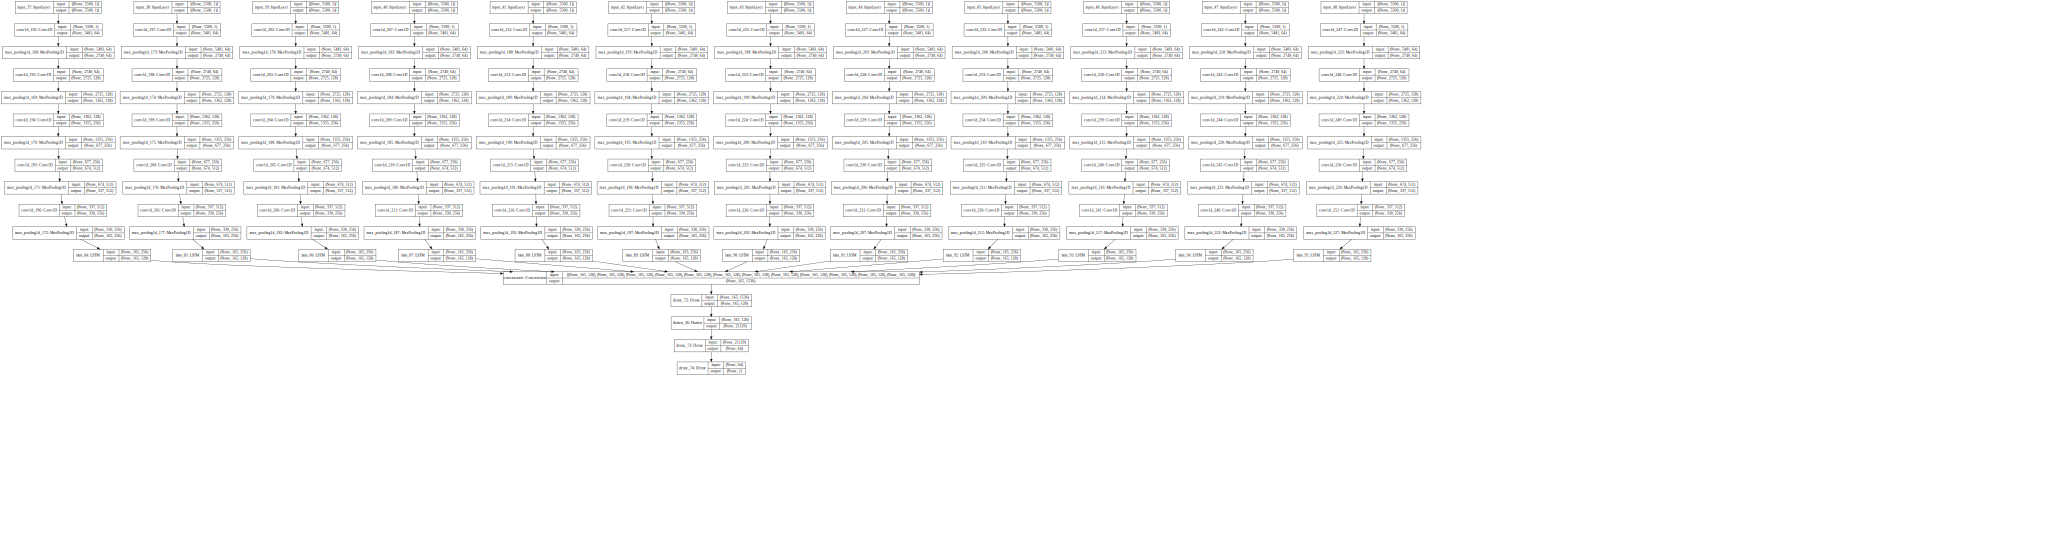

In [27]:
from IPython.display import SVG, display, clear_output
from keras.utils.vis_utils import model_to_dot

display(SVG(model_to_dot(model, show_shapes=True, dpi=50).create(prog='dot', format='svg')))


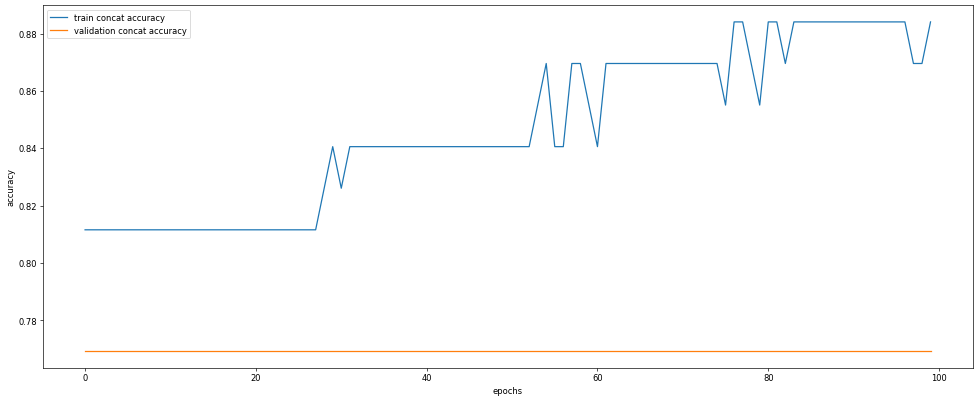

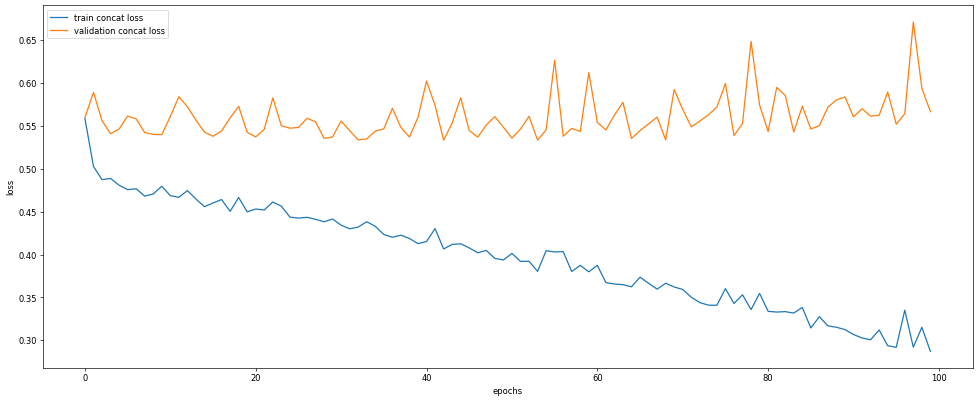

In [28]:
plt.figure(figsize=(20,8), dpi= 60)
plt.plot(history4.history['accuracy'],label='train concat accuracy')
plt.plot(history4.history['val_accuracy'],label='validation concat accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()

plt.show()

plt.figure(figsize=(20,8), dpi= 60)
plt.plot(history4.history['loss'],label='train concat loss')
plt.plot(history4.history['val_loss'],label='validation concat loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
plt.show()

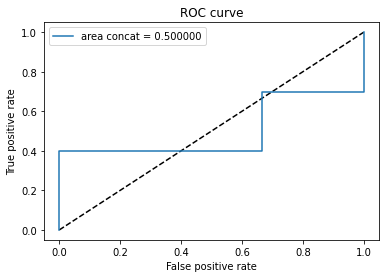

In [29]:
from sklearn.metrics import roc_curve
y_pred_keras = model.predict([X_test_LEAD_I, X_test_LEAD_II, X_test_LEAD_III, X_test_LEAD_AVR, X_test_LEAD_AVL, X_test_LEAD_AVF,
                              X_test_LEAD_V1, X_test_LEAD_V2, X_test_LEAD_V3, X_test_LEAD_V4, X_test_LEAD_V5, X_test_LEAD_V6])

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test_LEAD_V6, y_pred_keras)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='area concat = %3f' % (auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Modelo 5

In [30]:
lead['MDC_ECG_LEAD_AVF'][0]

array([[0.96984925, 0.95854922, 0.9009901 , ..., 0.        , 0.        ,
        0.        ],
       [0.57788945, 0.58031088, 0.56930693, ..., 0.        , 0.        ,
        0.        ],
       [0.4321608 , 0.43523316, 0.3960396 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.69346734, 0.69948187, 0.67821782, ..., 0.        , 0.        ,
        0.        ],
       [0.5678392 , 0.57512953, 0.55445545, ..., 0.        , 0.        ,
        0.        ],
       [0.55778894, 0.55440415, 0.53960396, ..., 0.        , 0.        ,
        0.        ]])

In [31]:
avf = lead['MDC_ECG_LEAD_AVL'][0].reshape(82,5500,1)
v1 = lead['MDC_ECG_LEAD_V4'][0].reshape(82,5500,1)
III = lead['MDC_ECG_LEAD_III'][0].reshape(82,5500,1)


arr = np.dstack((avf, v1,III))
arr.shape

(82, 5500, 3)

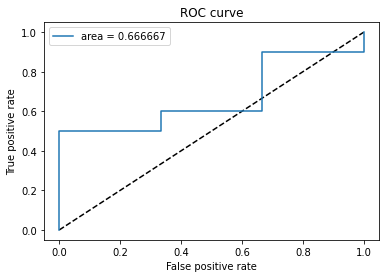

In [32]:
X = arr
y = lead_sev['MDC_ECG_LEAD_III'][0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

input = Input((5500,3))
ecg_model = Conv1D(64,kernel_size=21,strides=11)(input)
ecg_model = MaxPooling1D(pool_size=2)(ecg_model)
ecg_model = BatchNormalization()(ecg_model)
ecg_model = LeakyReLU(alpha=0.1)(ecg_model)
ecg_model = Dropout(rate=0.3)(ecg_model)
ecg_model = Conv1D(64,kernel_size=7,strides=1)(ecg_model)
ecg_model = MaxPooling1D(pool_size=2)(ecg_model)
ecg_model = BatchNormalization()(ecg_model)
ecg_model = Conv1D(128,kernel_size=5,strides=1)(ecg_model)
ecg_model = MaxPooling1D(pool_size=2)(ecg_model)
ecg_model = Conv1D(256,kernel_size=13,strides=1)(ecg_model)
ecg_model = Conv1D(512,kernel_size=7,strides=1)(ecg_model)
ecg_model = Dropout(rate=0.3)(ecg_model)
ecg_model = Conv1D(256,kernel_size=9,strides=1)(ecg_model)
ecg_model = MaxPooling1D(pool_size=2)(ecg_model)
ecg_model = LSTM(128, return_sequences=True)(ecg_model)
ecg_model = Flatten()(ecg_model)
ecg_model = Dense(64, activation='relu')(ecg_model)
o  = Dense(1, activation='sigmoid')(ecg_model)

model = Model(inputs = input, outputs = o)
opt = Adam(lr=0.0000001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=["accuracy"])

history5 = model.fit(X_train,y_train, epochs=100,verbose=0, validation_data=(X_test,y_test))

from IPython.display import SVG, display, clear_output
from keras.utils.vis_utils import model_to_dot


display(SVG(model_to_dot(model, show_shapes=True, dpi=50, rankdir='LR').create(prog='dot', format='svg')))

from sklearn.metrics import roc_curve
y_pred_keras = model.predict(X_test)

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='area = %3f' % ( auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

## Modelo 6

In [33]:

arr = np.dstack((lead['MDC_ECG_LEAD_I'][0].reshape(82,5500,1),lead['MDC_ECG_LEAD_II'][0].reshape(82,5500,1),lead['MDC_ECG_LEAD_III'][0].reshape(82,5500,1),lead['MDC_ECG_LEAD_AVR'][0].reshape(82,5500,1),lead['MDC_ECG_LEAD_AVL'][0].reshape(82,5500,1),lead['MDC_ECG_LEAD_AVF'][0].reshape(82,5500,1),
                 lead['MDC_ECG_LEAD_V1'][0].reshape(82,5500,1),lead['MDC_ECG_LEAD_V2'][0].reshape(82,5500,1),lead['MDC_ECG_LEAD_V3'][0].reshape(82,5500,1),lead['MDC_ECG_LEAD_V4'][0].reshape(82,5500,1),lead['MDC_ECG_LEAD_V5'][0].reshape(82,5500,1),lead['MDC_ECG_LEAD_V6'][0].reshape(82,5500,1)))
arr.shape

(82, 5500, 12)

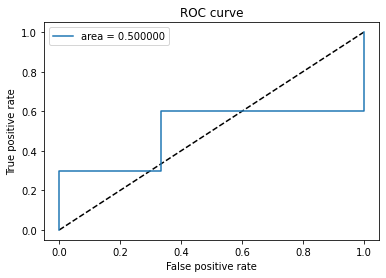

In [34]:
X = arr
y = lead_sev['MDC_ECG_LEAD_III'][0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

input = Input((5500,12))
ecg_model = Conv1D(64,kernel_size=21,strides=11)(input)
ecg_model = MaxPooling1D(pool_size=2)(ecg_model)
ecg_model = BatchNormalization()(ecg_model)
ecg_model = LeakyReLU(alpha=0.1)(ecg_model)
ecg_model = Dropout(rate=0.3)(ecg_model)
ecg_model = Conv1D(64,kernel_size=7,strides=1)(ecg_model)
ecg_model = MaxPooling1D(pool_size=2)(ecg_model)
ecg_model = BatchNormalization()(ecg_model)
ecg_model = Conv1D(128,kernel_size=5,strides=1)(ecg_model)
ecg_model = MaxPooling1D(pool_size=2)(ecg_model)
ecg_model = Conv1D(256,kernel_size=13,strides=1)(ecg_model)
ecg_model = Conv1D(512,kernel_size=7,strides=1)(ecg_model)
ecg_model = Dropout(rate=0.3)(ecg_model)
ecg_model = Conv1D(256,kernel_size=9,strides=1)(ecg_model)
ecg_model = MaxPooling1D(pool_size=2)(ecg_model)
ecg_model = LSTM(128, return_sequences=True)(ecg_model)
ecg_model = Flatten()(ecg_model)
ecg_model = Dense(64, activation='relu')(ecg_model)
o  = Dense(1, activation='sigmoid')(ecg_model)

model = Model(inputs = input, outputs = o)
opt = Adam(lr=0.0000001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=["accuracy"])

history6 = model.fit(X_train,y_train, epochs=100,verbose=0, validation_data=(X_test,y_test))

from IPython.display import SVG, display, clear_output
from keras.utils.vis_utils import model_to_dot


display(SVG(model_to_dot(model, show_shapes=True, dpi=50, rankdir='LR').create(prog='dot', format='svg')))

from sklearn.metrics import roc_curve
y_pred_keras = model.predict(X_test)

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='area = %3f' % ( auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()